In [1]:
#!pip install fastMONAI
from fastMONAI.vision_all import *
from monai.apps import DecathlonDataset
from sklearn.model_selection import train_test_split

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('data/SpineSegmentation/dataset.json') as f:
    dataset_json = json.load(f)
training_data = dataset_json['training']

In [3]:
df = pd.DataFrame(training_data)
df.shape

(131, 2)

In [4]:
# split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df.shape, test_df.shape

((117, 2), (14, 2))

In [5]:
os.chdir('/Users/haukebartsch/src/SpineSegmentationAI/data/SpineSegmentation')
os.getcwd()

'/Users/haukebartsch/src/SpineSegmentationAI/data/SpineSegmentation'

In [6]:
med_dataset = MedDataset(img_list=train_df.label.tolist(), dtype=MedMask, max_workers=12)

In [7]:
med_dataset.df.head()

,path,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,voxel_count_0,voxel_count_1
0,./labelsTr/1.3.6.1.4.1.45037.f2aaffbfad85d8482612afbc8ceae852ccba633c0c0fa.nii.gz,320,320,17,0.9375,0.9375,4.3999,PSR+,1700767,40033
1,./labelsTr/1.3.6.1.4.1.45037.f708b8ff302d0fd697529b79c0eb0a468c329774f388e.nii.gz,384,384,17,0.7813,0.7813,4.4000,PSR+,2442352,64400
2,./labelsTr/1.3.6.1.4.1.45037.5d7b0eddf0170092a2108ebf93386064c4cb159df1abe.nii.gz,384,384,17,0.7813,0.7813,4.4000,PSR+,2435329,71423
3,./labelsTr/1.3.6.1.4.1.45037.c34f076c0c8564ca87d37a308d4fe1dc73fd328c65b80.nii.gz,384,384,17,0.7812,0.7813,4.4000,PSR+,2445320,61432
4,./labelsTr/1.3.6.1.4.1.45037.e6ab5cdaa978e3f2d32f4bc012487371b788345ab0b44.nii.gz,384,384,17,0.7812,0.7812,4.4000,PSR+,2440138,66614


In [8]:
data_info_df = med_dataset.summary()

In [9]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
4,384,384,17,0.7812,0.7812,4.4,PSR+,./labelsTr/0b33311caf923f9a669cd7d52fc7f04b19e35ff0b60be1964215127f6f75b796.nii.gz,61
6,384,384,17,0.7813,0.7812,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.2bce302276ae4a8fd5a0ef292e7de24b4270270c73121.nii.gz,18
5,384,384,17,0.7812,0.7813,4.4,PSR+,./labelsTr/019c3523ce0e4048407dbce0946a5c6559665398d8051ffbc6053f228e0e8586.nii.gz,16
8,384,384,17,0.7813,0.7813,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.3ec342080cf70e4076cc71c5014e76afd85f30086d2bb.nii.gz,7
2,320,320,17,0.9375,0.9375,4.4,PSR+,./labelsTr/1.3.6.1.4.1.45037.3eb8a5011f2120b641058c4a540a5745422b1154f81f3.nii.gz,6


In [10]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.7812, 0.7812, 4.4], False)

In [11]:
bs=4
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[384.0, 384.0, 19.0]

In [12]:
size=[384,384,32]
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=0, degrees=5)]

In [13]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock),splitter=RandomSplitter(valid_pct=0.1, seed=42), get_x=ColReader('image'), get_y=ColReader('label'), item_tfms=item_tfms, reorder=reorder, resample=resample)

In [14]:
dls = dblock.dataloaders(train_df, bs=bs)

In [15]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(106, 11)

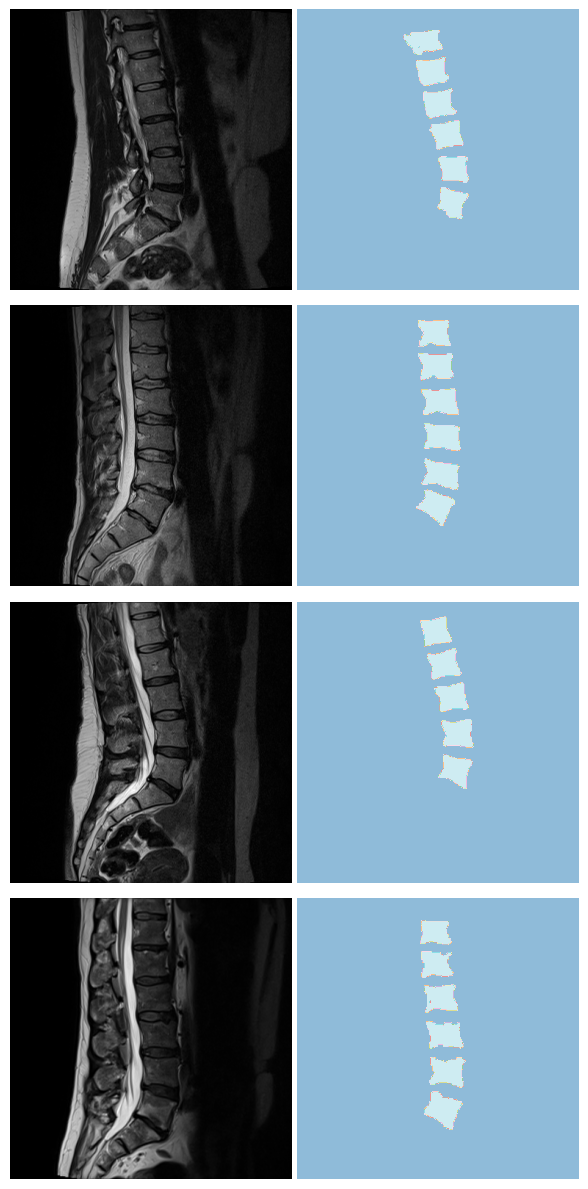

In [16]:
dls.show_batch(anatomical_plane=2)

In [17]:
from monai.networks.nets import UNet
from monai.losses import DiceLoss

In [18]:
model = UNet(spatial_dims=3, in_channels=1, out_channels=1, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2).to(torch.device("cpu"))
model = model.model


In [19]:
loss_func = CustomLoss(loss_func=DiceLoss(sigmoid=True))

In [20]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=binary_dice_score)

SuggestedLRs(valley=0.013182567432522774)

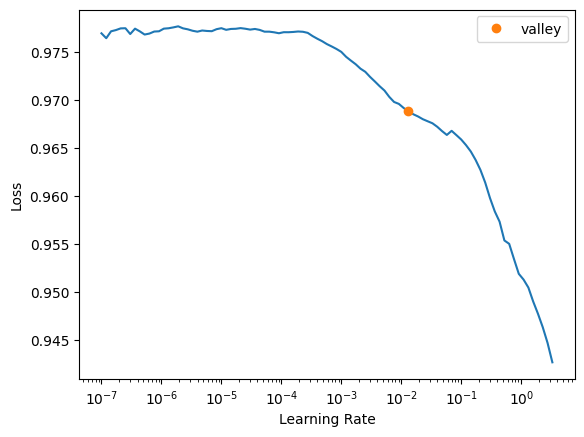

In [21]:
learn.dls.cpu()
learn.lr_find()

In [22]:
lr = 0.01318

In [23]:
learn.fit_flat_cos(200, lr)

epoch,train_loss,valid_loss,binary_dice_score,time
0,0.961860,0.956177,0.091672,04:55
1,0.954227,0.945643,0.176905,05:09
2,0.944715,0.928610,0.151608,05:01
3,0.926924,0.890358,0.166538,05:13
4,0.897554,0.834147,0.227030,05:13
5,0.845853,0.731500,0.366118,05:15
6,0.765875,0.589591,0.537195,05:12
7,0.659079,0.439932,0.606781,05:10
8,0.535009,0.275804,0.738834,05:07
9,0.416820,0.197203,0.804845,04:59


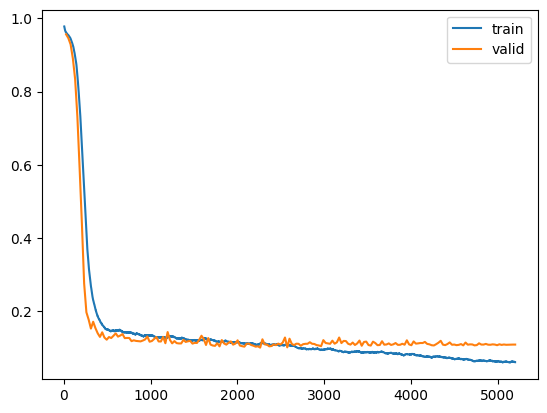

In [24]:
learn.recorder.plot_loss()

In [25]:
learn.save('spine-model')

Path('models/spine-model.pth')

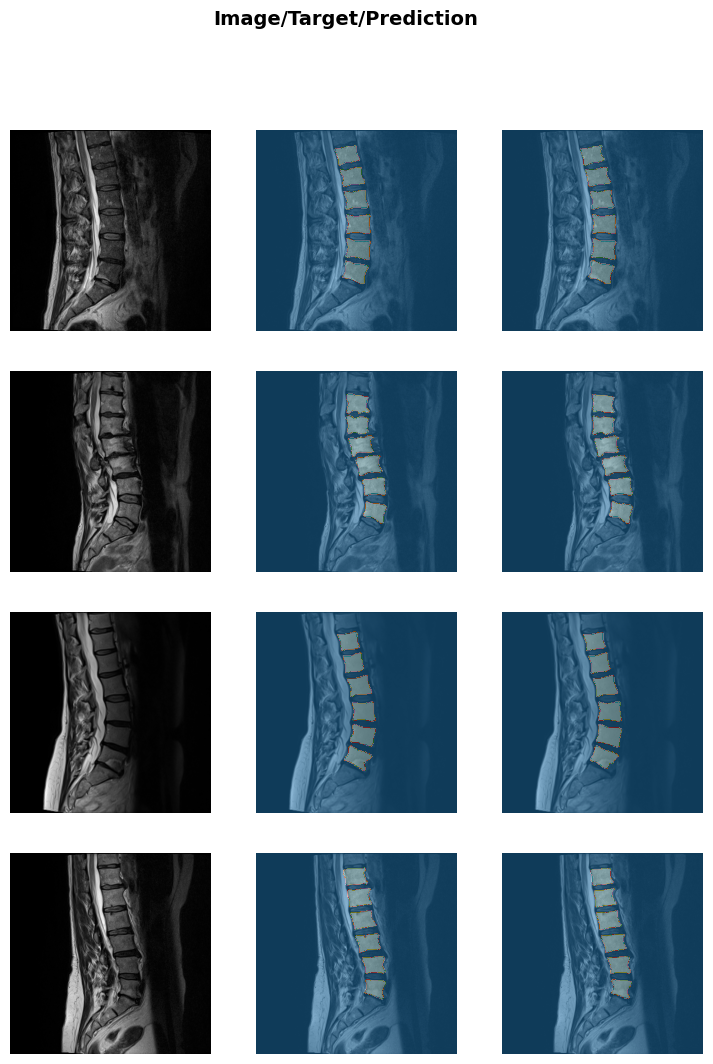

In [26]:
learn.show_results(anatomical_plane=2)

In [28]:
# export learner
store_variables(pkl_fn='vars.pkl', size=size, reorder=reorder, resample=resample)

In [29]:
learn.export('spine_model.pkl')

In [ ]:
# inference can be done by using SpineSegmentationInference.py